In [5]:
import pandas as pd
import numpy as np
import mne
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline
from sklearn.preprocessing import MinMaxScaler

In [6]:
df_mu = pd.read_csv("/content/MU.txt", sep='\s+', header=None, engine='python')
df_mu.columns = ['id', 'event', 'device', 'channel', 'code', 'size', 'data']

In [7]:
display (df_mu)

,id,event,device,channel,code,size,data
0,978111,132669,MU,TP9,6,459,"475,474,477,486,486,476,479,483,489,483,482,48..."
1,978112,132669,MU,FP1,6,459,"468,487,493,493,498,493,491,490,492,487,483,48..."
2,978113,132669,MU,FP2,6,459,"482,475,490,500,485,470,470,482,490,484,478,48..."
3,978114,132669,MU,TP10,6,459,"470,470,478,489,487,475,469,478,488,483,474,48..."
4,978115,132670,MU,TP9,7,493,"506,499,495,491,492,507,496,500,498,496,499,50..."
...,...,...,...,...,...,...,...
163927,1142038,173650,MU,TP10,-1,460,"537,531,530,531,533,537,537,555,534,522,531,54..."
163928,1142039,173651,MU,TP9,-1,460,"521,517,526,524,514,519,520,526,526,514,519,52..."
163929,1142040,173651,MU,FP1,-1,460,"525,518,522,525,523,523,512,523,519,522,523,52..."
163930,1142041,173651,MU,FP2,-1,460,"502,493,500,511,510,512,523,507,497,503,502,50..."


In [8]:
df_mu['signal'] = df_mu['data'].apply(lambda x: list(map(int, x.split(','))))
print(df_mu['signal'].head())

0    [475, 474, 477, 486, 486, 476, 479, 483, 489, ...
1    [468, 487, 493, 493, 498, 493, 491, 490, 492, ...
2    [482, 475, 490, 500, 485, 470, 470, 482, 490, ...
3    [470, 470, 478, 489, 487, 475, 469, 478, 488, ...
4    [506, 499, 495, 491, 492, 507, 496, 500, 498, ...
Name: signal, dtype: object


In [9]:
def bandpass_filter(signal, sfreq=220.0, lowcut=0.1, highcut=25):
    nyquist = 0.5 * sfreq
    low=lowcut / nyquist
    high=highcut / nyquist
    b, a = butter(4, [low, high], btype='band')
    y = filtfilt(b, a, signal)
    return y
    #highcut=25 because spike appears at 50 (the spike in the example shown in the preprocessing article appeared at 60
    #and they kept the highcut at 30)

In [10]:
df_mu['filtered_signal'] = df_mu['signal'].apply(lambda x: bandpass_filter(np.array(x)))

In [11]:
sample_index=56 #can tweak this to verify

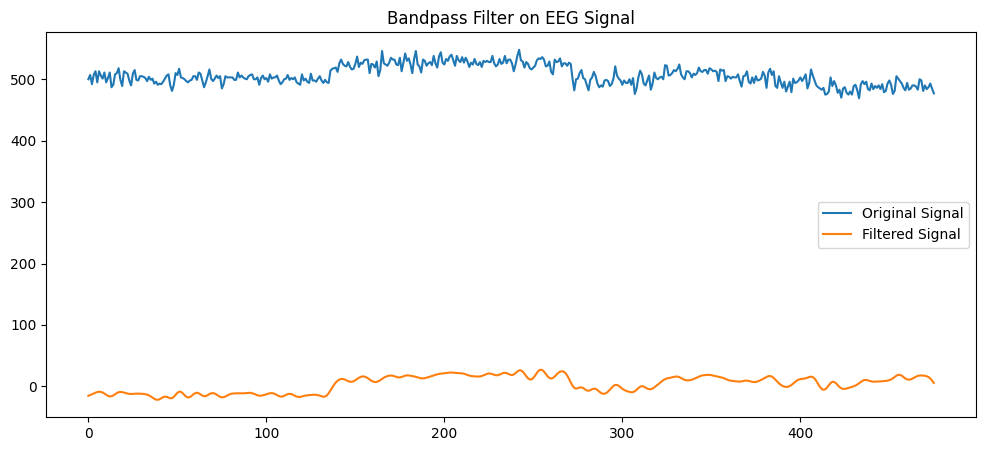

In [12]:
plt.figure(figsize=(12,5))
plt.plot(df_mu.loc[sample_index, 'signal'], label='Original Signal')
plt.plot(df_mu.loc[sample_index, 'filtered_signal'], label='Filtered Signal')
plt.legend()
plt.title('Bandpass Filter on EEG Signal')
plt.show()

In [13]:
#grouping according to the digit being shown
groups = df_mu.groupby('code')
for code_value, group_df in groups:
  print(f"Code Value: {code_value}")
  print(group_df.head())

Code Value: -1
             id   event device channel  code  size  \
119520  1097631  162549     MU     TP9    -1   460   
119521  1097632  162549     MU     FP1    -1   460   
119522  1097633  162549     MU     FP2    -1   460   
119523  1097634  162549     MU    TP10    -1   460   
119524  1097635  162550     MU     TP9    -1   460   

                                                     data  \
119520  522,540,548,539,535,545,553,554,551,552,554,54...   
119521  494,559,562,558,556,557,558,558,555,556,560,56...   
119522  556,558,606,558,542,590,590,590,542,542,574,57...   
119523  537,533,553,548,525,520,545,554,532,522,536,55...   
119524  482,473,473,488,496,488,484,491,488,492,480,47...   

                                                   signal  \
119520  [522, 540, 548, 539, 535, 545, 553, 554, 551, ...   
119521  [494, 559, 562, 558, 556, 557, 558, 558, 555, ...   
119522  [556, 558, 606, 558, 542, 590, 590, 590, 542, ...   
119523  [537, 533, 553, 548, 525, 520, 545, 554, 

In [25]:
#need to remove data with code value = -1 (random or no stimulus was shown)
df_mu_filtered = df_mu[df_mu['code'] != -1]
groups=df_mu_filtered.groupby('code')
for code_value, group_df in groups:
  print(f"Code Value: {code_value}")
  print(group_df.head())

Code Value: 0
         id   event device channel  code  size  \
60   978171  132684     MU     TP9     0   476   
61   978172  132684     MU     FP1     0   476   
62   978173  132684     MU     FP2     0   476   
63   978174  132684     MU    TP10     0   476   
100  978211  132694     MU     TP9     0   459   

                                                  data  \
60   516,533,532,526,528,528,532,541,540,536,532,52...   
61   514,523,525,521,521,524,522,524,525,522,523,52...   
62   520,515,516,512,513,512,515,516,515,509,517,51...   
63   533,507,506,511,511,513,513,518,524,511,506,51...   
100  524,530,534,537,535,538,533,530,528,523,516,51...   

                                                signal  \
60   [516, 533, 532, 526, 528, 528, 532, 541, 540, ...   
61   [514, 523, 525, 521, 521, 524, 522, 524, 525, ...   
62   [520, 515, 516, 512, 513, 512, 515, 516, 515, ...   
63   [533, 507, 506, 511, 511, 513, 513, 518, 524, ...   
100  [524, 530, 534, 537, 535, 538, 533, 530, 

In [15]:
print("\nMissing values in each column:")
print(df_mu_filtered.isnull().sum())
#no missing values


Missing values in each column:
id                 0
event              0
device             0
channel            0
code               0
size               0
data               0
signal             0
filtered_signal    0
dtype: int64


In [16]:
#resampling to median length using CubicSpline
median_length=int(np.median(df_mu_filtered['filtered_signal'].apply(len)))
print("Median Length =",median_length)

def resample_signal(signal, target_length=median_length):
    original_length = len(signal)
    if original_length == target_length:
        return signal
    x_old =  np.linspace(0, 1, original_length)
    x_new = np.linspace(0, 1, target_length)
    cs = CubicSpline(x_old, signal)
    resampled_signal = cs(x_new)
    return resampled_signal

df_mu_filtered['resampled_signal']=df_mu_filtered['filtered_signal'].apply(lambda x: resample_signal(np.array(x), median_length))

Median Length = 476


<ipython-input-16-4f1ae0435947>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mu_filtered['resampled_signal']=df_mu_filtered['filtered_signal'].apply(lambda x: resample_signal(np.array(x), median_length))


In [17]:
print(len(df_mu_filtered.loc[sample_index, 'resampled_signal']))
#can check by any signal, they have all been resampled to the median length i.e. 476

476


In [18]:
#normalising
def normalise_signal(signal):
  signal=np.array(signal).reshape(-1,1)
  scaler=MinMaxScaler()
  scaler.fit(signal)
  signal=scaler.transform(signal)
  return signal

df_mu_filtered['data_normalised']=df_mu_filtered['resampled_signal'].apply(normalise_signal)

<ipython-input-18-67ee54a43d6f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mu_filtered['data_normalised']=df_mu_filtered['resampled_signal'].apply(normalise_signal)


In [20]:
df=df_mu_filtered

In [21]:
print(type(df['data'].iloc[0]), type(df['resampled_signal'].iloc[0]), type(df['data_normalised'].iloc[0]))


<class 'str'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [22]:
df['data'] = df['data'].apply(lambda x: list(map(int, x.split(','))) if isinstance(x, str) else x)

<ipython-input-22-832cb8f72477>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['data'] = df['data'].apply(lambda x: list(map(int, x.split(','))) if isinstance(x, str) else x)


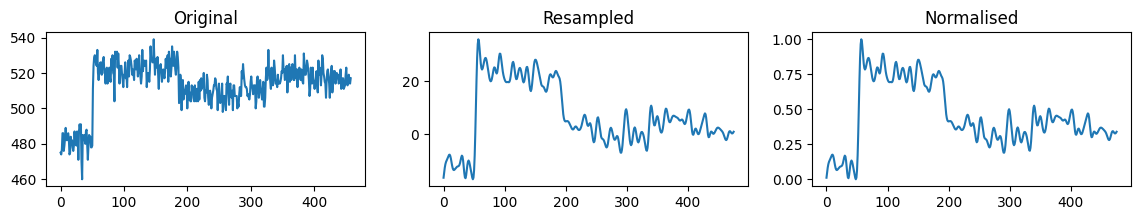

In [23]:
plt.figure(figsize=(14,2))
original=df['data'].iloc[0]
resampled=df['resampled_signal'].iloc[0]
normalised=df['data_normalised'].iloc[0]

plt.subplot(1,3,1)
plt.plot(original)
plt.title('Original')

plt.subplot(1,3,2)
plt.plot(resampled)
plt.title('Resampled')

plt.subplot(1,3,3)
plt.plot(normalised)
plt.title('Normalised')

plt.show()

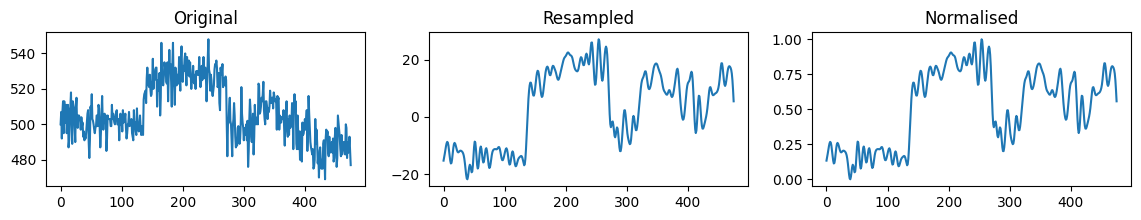

In [24]:
#plotting for a sample index
df=df_mu_filtered
plt.figure(figsize=(14,2))
original=df['data'].iloc[sample_index]
resampled=df['resampled_signal'].iloc[sample_index]
normalised=df['data_normalised'].iloc[sample_index]

plt.subplot(1,3,1)
plt.plot(original)
plt.title('Original')

plt.subplot(1,3,2)
plt.plot(resampled)
plt.title('Resampled')

plt.subplot(1,3,3)
plt.plot(normalised)
plt.title('Normalised')

plt.show()